## Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, MulticlassConfusionMatrix
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2
import copy
import gc 
import time

In [ ]:
import spoofdet.config as config
from spoofdet.model_utils import gpu_transforms_train, gpu_transforms_val, evaluate_model, train_model, checkImage, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result
from spoofdet.dataset import CelebASpoofDataset

## randomizer

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Model


In [ ]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

for param in model.features.parameters():
    param.requires_grad = False

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to C:\Users\Josh/.cache\torch\hub\checkpoints\efficientnet_v2_m-dc08266a.pth


100%|██████████| 208M/208M [00:05<00:00, 39.7MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## preparation


In [ ]:
import multiprocessing
from torch.utils.data import Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"

num_cpus = multiprocessing.cpu_count()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

device

Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


device(type='cuda')

In [ ]:
all_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    bbox_json_path=bbox_lookup,
    target_size = config.TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=bbox_lookup,
    target_size = config.TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

train_ds = Subset(all_ds, range(0, int(0.5 * len(all_ds))))
val_ds = Subset(all_ds, range(int(0.5 * len(all_ds)), len(all_ds)))


In [10]:
len(train_ds)

247202

In [ ]:

np.random.seed(seed)

small_train_ds = create_subset(train_ds.dataset, total_size=3000, spoof_percent=config.SPOOF_PERCENT)
small_val_ds = create_subset(val_ds.dataset, total_size=1000, spoof_percent=config.SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=400)
print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning internal label dict for class balance...
 Found: 162462 Live | 331943 Spoof
 Scanning internal label dict for class balance...
 Found: 162462 Live | 331943 Spoof
Created Balanced Train: 3000 images


In [ ]:
len(small_train_ds)

3000

In [13]:
len(small_val_ds)

1000

In [ ]:

# 1 = spoof  0 = live 
checkImage(small_train_ds, 210)

In [ ]:
# check distribution of live and spoof in small_test_ds
checkDatasetDistribution(small_test_ds)

Live count: 200, Spoof count: 200


In [16]:
checkDatasetDistribution(small_train_ds)

Live count: 900, Spoof count: 2100


In [17]:
checkDatasetDistribution(small_val_ds)

Live count: 300, Spoof count: 700


## Data Loader

In [ ]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=config.BATCH_SIZE, 
                                shuffle=True,
                                num_workers=config.WORKERS,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              persistent_workers=True
                
                    
)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=config.BATCH_SIZE, 
                               shuffle=False,
                                num_workers=config.WORKERS,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [19]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 500, 500]), tensor(1))

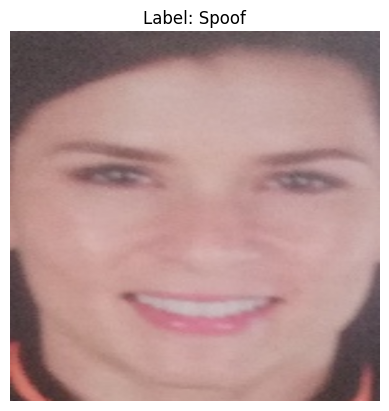

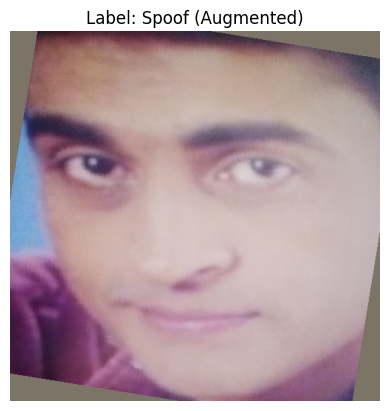

In [ ]:


checkAugmentedImage(small_train_ds, 2, gpu_transforms=gpu_transforms_train)

## Train

In [ ]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,      
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=config.EPOCHS, 
                             early_stopping_limit=config.EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val
                             )

Epoch [1/100] | Time: 1m 36s Train Loss: 0.5572 | Val Loss: 0.5167 | Val Precision: 0.85% | Val Accuracy: 0.84% | Val Recall: 0.94% | Val F1: 0.89%
  -> New best model saved!
Epoch [2/100] | Time: 0m 56s Train Loss: 0.4460 | Val Loss: 0.4281 | Val Precision: 0.93% | Val Accuracy: 0.90% | Val Recall: 0.93% | Val F1: 0.93%
  -> New best model saved!
Epoch [3/100] | Time: 0m 56s Train Loss: 0.3823 | Val Loss: 0.3922 | Val Precision: 0.97% | Val Accuracy: 0.90% | Val Recall: 0.89% | Val F1: 0.93%
  -> New best model saved!
Epoch [4/100] | Time: 0m 56s Train Loss: 0.3356 | Val Loss: 0.3624 | Val Precision: 0.97% | Val Accuracy: 0.90% | Val Recall: 0.89% | Val F1: 0.93%
  -> New best model saved!
Epoch [5/100] | Time: 0m 57s Train Loss: 0.3034 | Val Loss: 0.3543 | Val Precision: 0.97% | Val Accuracy: 0.89% | Val Recall: 0.87% | Val F1: 0.92%
  -> New best model saved!
Epoch [6/100] | Time: 0m 58s Train Loss: 0.2813 | Val Loss: 0.2807 | Val Precision: 0.97% | Val Accuracy: 0.92% | Val Recall:

C:\Users\Josh\AppData\Local\Temp\ipykernel_6672\163929919.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
C:\Users\Josh\AppData\Local\Temp\ipykernel_6672\163929919.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


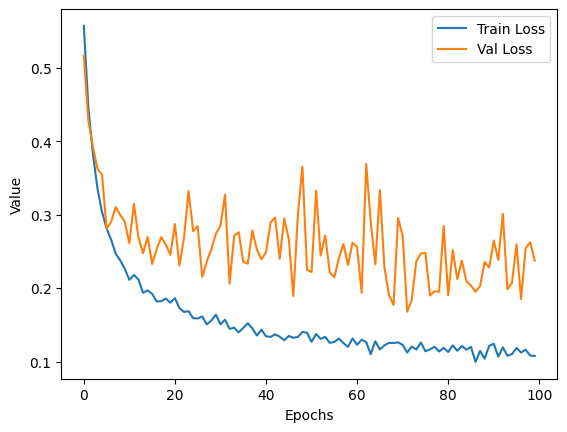

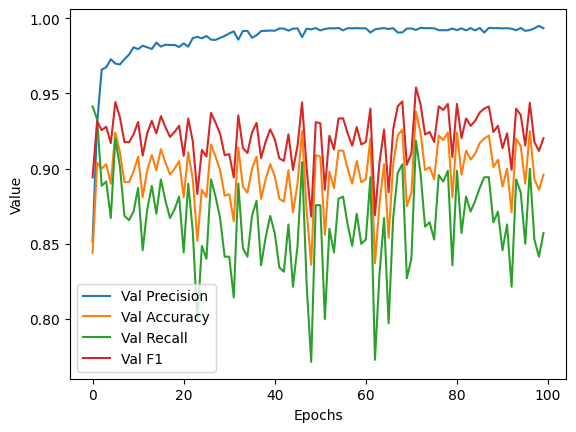

In [ ]:




train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           199     |          1
Spoof           44     |        156


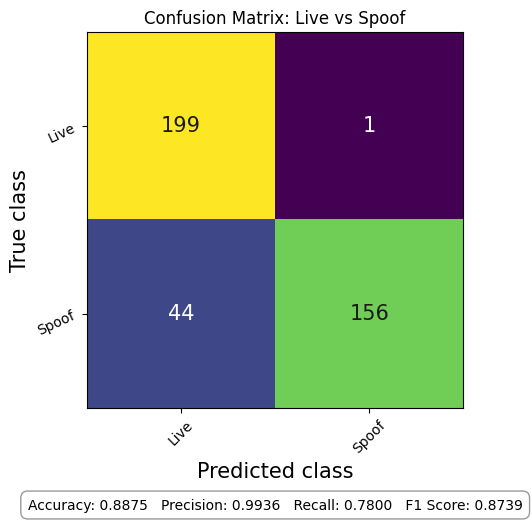

Accuracy: 0.8875
Precision: 0.9936
Recall:    0.7800
F1 Score:  0.8739


In [ ]:
confusion_matrix, accuracy, precision, recall, f1 = evaluate_model(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val)

In [ ]:
from pathlib import Path
def _create_save_new_path(save_path: Path, path_name: str, num: int) -> Path:
    new_dir = save_path / f"{path_name}_{num}"
    if new_dir.exists():
        return _create_save_new_path(save_path, path_name, num + 1)
    else:
        new_dir.mkdir(parents=True)
        return new_dir



def save_results(model: torch.nn.Module, confusion_matrix_fig: plt.Figure, train_loss_fig: plt.Figure, precision_fig: plt.Figure):
    
    save_path = Path("train_results")
    path_name = "train"
    num = 0
    
    save_path.mkdir(parents=True, exist_ok=True)
    
    # create new dir if already exist
    new_path = _create_save_new_path(save_path, path_name, num)

    print(f"Saving results to: {new_path}")

    confusion_matrix_fig.savefig(new_path / "confusion_matrix.png", bbox_inches='tight')
    train_loss_fig.savefig(new_path / "train_loss.png")
    precision_fig.savefig(new_path / "precision.png")

    torch.save(model.state_dict(), new_path / "model.pt")
save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig)

Saving results to: train_results\train_10


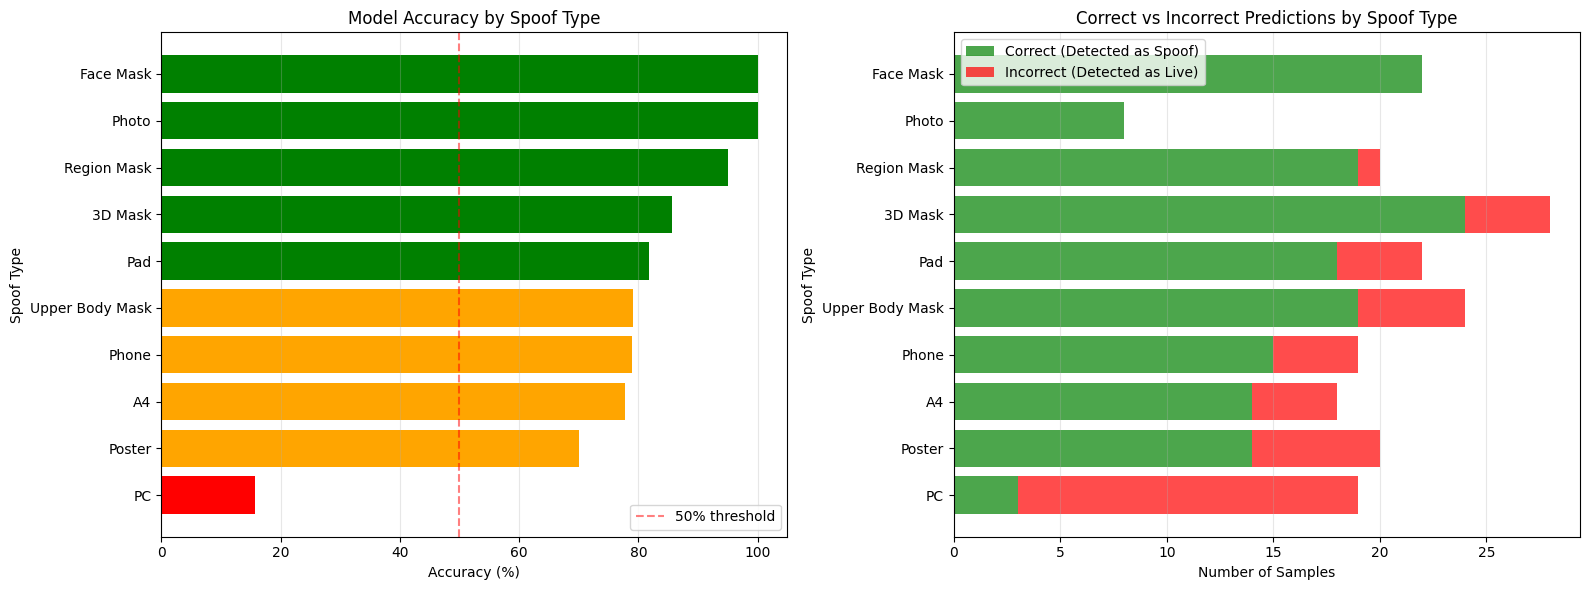


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     19        3         16     15.789474
         Poster        2     20       14          6     70.000000
             A4        3     18       14          4     77.777778
          Phone        9     19       15          4     78.947368
Upper Body Mask        5     24       19          5     79.166667
            Pad        8     22       18          4     81.818182
        3D Mask       10     28       24          4     85.714286
    Region Mask        6     20       19          1     95.000000
          Photo        1      8        8          0    100.000000
      Face Mask        4     22       22          0    100.000000


Worst Performing Spoof Types (Accuracy < 70%):
Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
        PC        7     19        3         16     15.789474


In [ ]:
def analyze_spoof_types(model: torch.nn.Module, dataset, device: torch.device, val_transforms: v2.Compose):
    """
    Analyzes model performance across different spoof types.
    Spoof type is at index 40 in the label array.
    """
    spoof_type_labels = {
        0: 'Live',
        1: 'Photo',
        2: 'Poster',
        3: 'A4',
        4: 'Face Mask',
        5: 'Upper Body Mask',
        6: 'Region Mask',
        8: 'Pad',
        7: "PC",
        9: 'Phone',
        10: '3D Mask'
    }
    
    model.eval()
    
    # Dictionary to store results per spoof type
    spoof_type_results = {}
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            
            # Get the original key to access full label info
            if hasattr(dataset, 'dataset'):  # If it's a Subset
                actual_idx = dataset.indices[idx]
                image_key = dataset.dataset.image_keys[actual_idx]
                full_labels = dataset.dataset.label_dict[image_key]
            else:
                image_key = dataset.image_keys[idx]
                full_labels = dataset.label_dict[image_key]
            
            spoof_type = full_labels[40]  # Spoof type at index 40
            live_spoof_label = full_labels[43]  # Live/Spoof at index 43
            
            # Only analyze spoof images (label = 1)
            if live_spoof_label != 1:
                continue
            
            # Prepare image for model
            img = img.unsqueeze(0).to(device)
            img = val_transforms(img)
            
            # Get prediction
            output = model(img)
            pred = torch.argmax(output, dim=1).item()
            
            # Initialize spoof type entry if needed
            if spoof_type not in spoof_type_results:
                spoof_type_results[spoof_type] = {
                    'total': 0,
                    'correct': 0,
                    'incorrect': 0
                }
            
            # Update statistics
            spoof_type_results[spoof_type]['total'] += 1
            if pred == 1:  # Correctly identified as spoof
                spoof_type_results[spoof_type]['correct'] += 1
            else:  # Incorrectly identified as live
                spoof_type_results[spoof_type]['incorrect'] += 1
    
    # Calculate accuracy per spoof type
    results_df = []
    for spoof_type, stats in sorted(spoof_type_results.items()):
        accuracy = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
        results_df.append({
            'Spoof Type': spoof_type_labels.get(spoof_type, 'Unknown'),
            'Type ID': spoof_type,
            'Total': stats['total'],
            'Correct': stats['correct'],
            'Incorrect': stats['incorrect'],
            'Accuracy (%)': accuracy
        })
    
    results_df = pd.DataFrame(results_df)
    results_df = results_df.sort_values('Accuracy (%)')
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of accuracy per spoof type
    ax1.barh(results_df['Spoof Type'].astype(str), results_df['Accuracy (%)'], 
             color=['red' if x < 50 else 'orange' if x < 80 else 'green' 
                    for x in results_df['Accuracy (%)']])
    ax1.set_xlabel('Accuracy (%)')
    ax1.set_ylabel('Spoof Type')
    ax1.set_title('Model Accuracy by Spoof Type')
    ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # Stacked bar chart showing correct vs incorrect
    ax2.barh(results_df['Spoof Type'].astype(str), results_df['Correct'], 
             label='Correct (Detected as Spoof)', color='green', alpha=0.7)
    ax2.barh(results_df['Spoof Type'].astype(str), results_df['Incorrect'], 
             left=results_df['Correct'], label='Incorrect (Detected as Live)', 
             color='red', alpha=0.7)
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Spoof Type')
    ax2.set_title('Correct vs Incorrect Predictions by Spoof Type')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSpoof Type Analysis Results:")
    print("=" * 80)
    print(results_df.to_string(index=False))
    print("\n" + "=" * 80)
    print(f"\nWorst Performing Spoof Types (Accuracy < 70%):")
    worst = results_df[results_df['Accuracy (%)'] < 70]
    if len(worst) > 0:
        print(worst.to_string(index=False))
    else:
        print("None - All spoof types have >70% accuracy!")
    
    return results_df, fig

# Run the analysis
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [28]:
# Check a few samples
for i in range(5):
    _, label = small_test_ds[i]
    print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

Sample 0: Label = 1 (Spoof)
Sample 1: Label = 1 (Spoof)
Sample 2: Label = 0 (Live)
Sample 3: Label = 1 (Spoof)
Sample 4: Label = 0 (Live)


In [29]:
# Test with a known Live sample
img, label = small_test_ds[2]  # Adjust index to find a Live sample
print(f"True label: {'Live' if label == 0 else 'Spoof'}")

img = img.unsqueeze(0).to(device)
img = gpu_transforms_val(img)
output = model(img)
pred = torch.argmax(output, dim=1).item()
print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

True label: Live
Predicted: Live


Analyzing spoof type distribution...


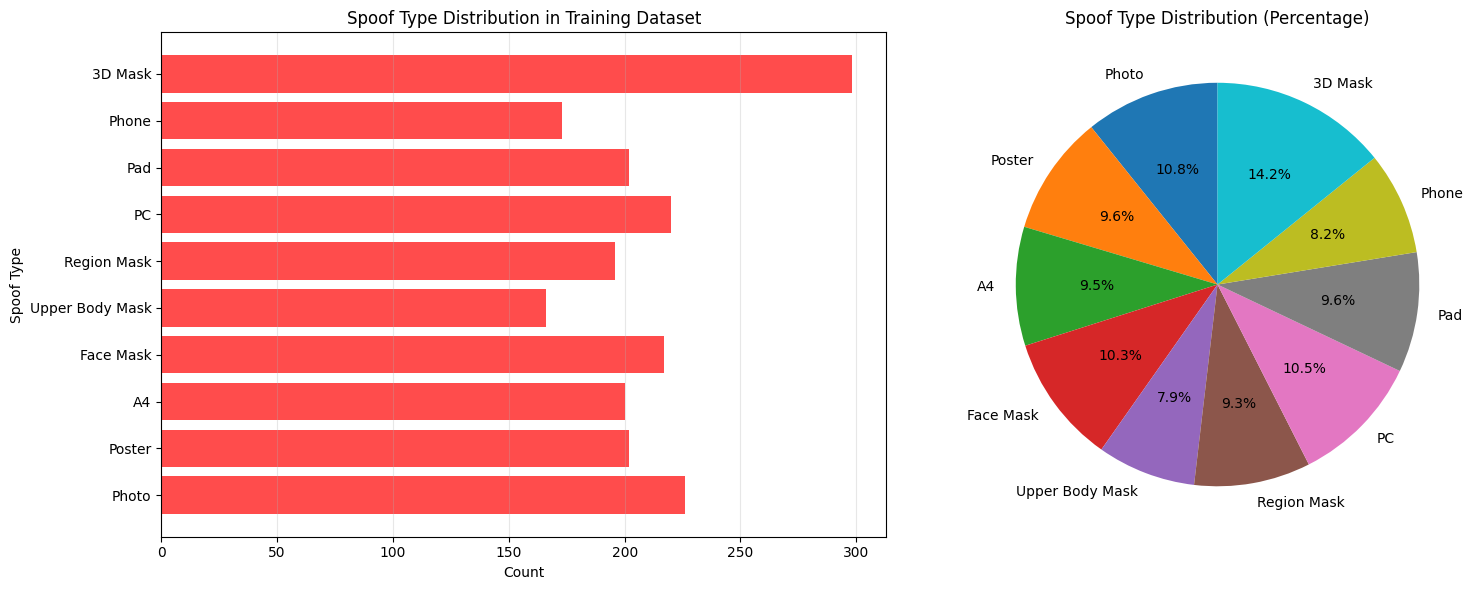


Spoof Type Distribution:
     Spoof Type  Type ID  Count  Percentage
          Photo        1    226        7.53
         Poster        2    202        6.73
             A4        3    200        6.67
      Face Mask        4    217        7.23
Upper Body Mask        5    166        5.53
    Region Mask        6    196        6.53
             PC        7    220        7.33
            Pad        8    202        6.73
          Phone        9    173        5.77
        3D Mask       10    298        9.93

Total samples: 3000
Live samples: 900 (30.00%)
Spoof samples: 2100 (70.00%)


In [31]:
def analyze_dataset_spoof_distribution(dataset):
    """
    Analyzes the distribution of spoof types in the dataset.
    """
    spoof_type_labels = {
        0: 'Live',
        1: 'Photo',
        2: 'Poster',
        3: 'A4',
        4: 'Face Mask',
        5: 'Upper Body Mask',
        6: 'Region Mask',
        7: "PC",
        8: 'Pad',
        9: 'Phone',
        10: '3D Mask'
    }
    
    spoof_type_counts = {}
    live_count = 0
    
    print("Analyzing spoof type distribution...")
    
    for idx in range(len(dataset)):
        # Get the original key to access full label info
        if hasattr(dataset, 'dataset'):  # If it's a Subset
            actual_idx = dataset.indices[idx]
            image_key = dataset.dataset.image_keys[actual_idx]
            full_labels = dataset.dataset.label_dict[image_key]
        else:
            image_key = dataset.image_keys[idx]
            full_labels = dataset.label_dict[image_key]
        
        live_spoof_label = full_labels[43]  # Live/Spoof at index 43
        
        if live_spoof_label == 0:  # Live
            live_count += 1
        else:  # Spoof
            spoof_type = full_labels[40]  # Spoof type at index 40
            spoof_type_counts[spoof_type] = spoof_type_counts.get(spoof_type, 0) + 1
    
    # Create DataFrame
    results = []
    for spoof_type, count in sorted(spoof_type_counts.items()):
        results.append({
            'Spoof Type': spoof_type_labels.get(spoof_type, 'Unknown'),
            'Type ID': spoof_type,
            'Count': count
        })
    
    results_df = pd.DataFrame(results)
    results_df['Percentage'] = (results_df['Count'] / len(dataset) * 100).round(2)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    colors = ['green' if row['Spoof Type'] == 'Live' else 'red' for _, row in results_df.iterrows()]
    ax1.barh(results_df['Spoof Type'], results_df['Count'], color=colors, alpha=0.7)
    ax1.set_xlabel('Count')
    ax1.set_ylabel('Spoof Type')
    ax1.set_title('Spoof Type Distribution in Training Dataset')
    ax1.grid(axis='x', alpha=0.3)
    
    # Pie chart
    ax2.pie(results_df['Count'], labels=results_df['Spoof Type'], autopct='%1.1f%%', startangle=90)
    ax2.set_title('Spoof Type Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
    
    print("\nSpoof Type Distribution:")
    print("=" * 60)
    print(results_df.to_string(index=False))
    print("=" * 60)
    print(f"\nTotal samples: {len(dataset)}")
    print(f"Live samples: {live_count} ({live_count/len(dataset)*100:.2f}%)")
    print(f"Spoof samples: {len(dataset) - live_count} ({(len(dataset) - live_count)/len(dataset)*100:.2f}%)")
    
    return results_df, fig

# Analyze training dataset distribution
train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_train_ds)